<a href="https://colab.research.google.com/github/pan-emily/protein-clip/blob/main/layer_peptide_clip_for_group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic CLIP dataloading
## 10/5/2023
This notebook will walk through the basics of getting some peptide-receptor data, loading and running it through ESM, and discuss some basic ideas we could work on

## Get the data
A good starting dataset is http://bioinfo.dcc.ufmg.br/propedia/, which contains peptide-protein complexes in fasta format. The fasta format isn't really well-defined, but it's very easy to understand / parse. This code is not meant to be super-efficient, mostly focused on pedagogy, so feel free to change heavily!

### NOTE:
Python3.12 came out today and is breaking all my workflows. Set to 3.10 or 3.11 in virtual environments!

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.3 MB/s eta 0:00:00


In [ ]:




from pathlib import Path
import requests

In [ ]:
if not Path('receptor.fasta').exists():
    r = requests.get('http://bioinfo.dcc.ufmg.br/propedia/public/download/receptor.fasta')
    assert r.ok
    with open('receptor.fasta', 'w+') as f:
        f.write(r.text)

if not Path('peptide.fasta').exists():
    r = requests.get('http://bioinfo.dcc.ufmg.br/propedia/public/download/peptide.fasta')
    assert r.ok
    with open('peptide.fasta', 'w+') as f:
        f.write(r.text)

In [ ]:
peptides, receptors = [], []
with open('receptor.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            receptors.append(line.replace('\n', ''))

with open('peptide.fasta', 'r') as f:
    for line in f.readlines():
        if not line.startswith('>'):
            peptides.append(line.replace('\n', ''))
assert len(peptides) == len(receptors)

In [ ]:
peptide_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/peptide.fasta'
receptor_url = 'http://bioinfo.dcc.ufmg.br/propedia/public/download/receptor.fasta'
peptide_data = requests.get(peptide_url).text
receptor_data = requests.get(receptor_url).text
with open('peptide.fasta', 'w') as f:
  f.write(peptide_data)
with open('receptor.fasta', 'w') as f:
  f.write(receptor_data)

In [ ]:
!wget https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
!tar xvzf mmseqs-linux-avx2.tar.gz
!cp mmseqs/bin/mmseqs /usr/bin/
!pip install biopython

--2023-10-20 17:05:48--  https://mmseqs.com/latest/mmseqs-linux-avx2.tar.gz
Resolving mmseqs.com (mmseqs.com)... 147.46.145.74
Connecting to mmseqs.com (mmseqs.com)|147.46.145.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45098845 (43M) [application/octet-stream]
Saving to: ‘mmseqs-linux-avx2.tar.gz’

mmseqs-linux-avx2.t 100%[===================>]  43.01M  4.72MB/s    in 7.2s    

2023-10-20 17:05:56 (5.97 MB/s) - ‘mmseqs-linux-avx2.tar.gz’ saved [45098845/45098845]

mmseqs/
mmseqs/bin/
mmseqs/bin/mmseqs
mmseqs/matrices/
mmseqs/matrices/blosum90.out
mmseqs/matrices/blosum50.out
mmseqs/matrices/blosum75.out
mmseqs/matrices/PAM50.out
mmseqs/matrices/blosum45.out
mmseqs/matrices/VTML120.out
mmseqs/matrices/blosum65.out
mmseqs/matrices/PAM60.out
mmseqs/matrices/VTML20.out
mmseqs/matrices/PAM100.out
mmseqs/matrices/PAM10.out
mmseqs/matrices/PAM120.out
mmseqs/matrices/PAM70.out
mmseqs/matrices/PAM40.out
mmseqs/matrices/nucleotide.out
mmseqs/matrices/blosum85.ou

In [ ]:
import os
import glob
from Bio import SeqIO

for filename in glob.glob('*cluster_res*'):
  try:
    os.remove(filename)
    print(f'Deleted: {filename}')
  except OSError as e:
    print(f'Error: {filename} : {e.strerror}')

# creating a database from the peptide fasta file
!mmseqs createdb peptide.fasta peptides_DB

# clustering the sequences
!mmseqs cluster peptides_DB cluster_res tmp --min-seq-id 0.5

# convert cluster results to flat file format
!mmseqs createtsv peptides_DB peptides_DB cluster_res cluster_res.tsv

peptide_to_cluster = {}
cluster_list = []
with open('cluster_res.tsv', 'r') as f:
  for line in f:
    cluster_id, peptide_id = line.strip().split('\t')
    peptide_to_cluster[peptide_id] = cluster_id
    cluster_list.append(cluster_id)

# creating a list of cluster indices for peptides in original order
cluster_indices = []
peptides = list(SeqIO.parse('peptide.fasta', 'fasta'))
for peptide in peptides:
  cluster_indices.append(cluster_list.index(peptide_to_cluster[peptide.id]))

createdb peptide.fasta peptides_DB 

MMseqs Version:       	bb0a1b3569b9fe115f3bf63e5ba1da234748de23
Database type         	0
Shuffle input database	true
Createdb mode         	0
Write lookup file     	1
Offset of numeric ids 	0
Compressed            	0
Verbosity             	3

Converting sequences
[19797] 0s 38ms
Time for merging to peptides_DB_h: 0h 0m 0s 5ms
Time for merging to peptides_DB: 0h 0m 0s 4ms
Database type: Aminoacid
Time for processing: 0h 0m 0s 87ms
Create directory tmp
cluster peptides_DB cluster_res tmp --min-seq-id 0.5 

MMseqs Version:                     	bb0a1b3569b9fe115f3bf63e5ba1da234748de23
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nuc

[389, 328, 302, 212, 201, 200, 189, 182, 181, 176, 176, 168, 165, 130, 124, 116, 115, 101, 94, 92, 84, 81, 80, 76, 74, 71, 70, 60, 59, 57, 54, 50, 48, 48, 48, 47, 45, 45, 44, 44, 42, 41, 41, 41, 41, 38, 38, 37, 36, 36, 35, 34, 34, 32, 32, 31, 31, 30, 30, 30, 30, 30, 30, 29, 28, 28, 28, 27, 26, 26, 25, 25, 24, 24, 24, 24, 23, 23, 23, 23, 22, 22, 22, 22, 22, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

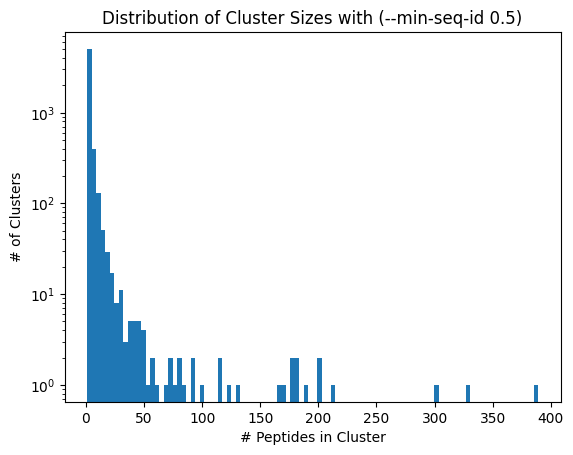

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

cluster_id_to_peptides = defaultdict(list)
for i in range(len(peptides)):
  cluster_id_to_peptides[cluster_indices[i]].append(peptides[i].seq)

all = []
for i in cluster_id_to_peptides.values():
  all.append(len(i))
all.sort(reverse=True)

plt.hist(all, bins=100)
plt.title("Distribution of Cluster Sizes with (--min-seq-id 0.5)")
plt.ylabel("# of Clusters")
plt.xlabel("# Peptides in Cluster")
plt.yscale('log')
print(all)

In [ ]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

def set_seed(seed_value=39084320):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

set_seed()

clusters = list(set(cluster_list))
print(f"N Peptides: {len(cluster_list)}")
print(f"N Clusters: {len(clusters)}")
random.shuffle(clusters)

# Splitting clusters
num_clusters = len(clusters)
train_cutoff = int(0.7 * num_clusters)
val_cutoff = train_cutoff + ((len(clusters) - train_cutoff) // 2)

train_clusters = set(clusters[:train_cutoff])
val_clusters = set(clusters[train_cutoff:val_cutoff])
test_clusters = set(clusters[val_cutoff:])

# Extracting peptides based on clusters
train_peptides, val_peptides, test_peptides = [], [], []
train_receptors, val_receptors, test_receptors = [], [], []

assert len(peptides) == len(receptors)

for i in range(len(peptides)):
    cluster_id = peptide_to_cluster[peptides[i].id]
    if cluster_id in train_clusters:
        train_peptides.append(peptides[i])
        train_receptors.append(receptors[i])
    elif cluster_id in val_clusters:
        val_peptides.append(peptides[i])
        val_receptors.append(receptors[i])

# Save the peptides in train, validation and test sets
with open("train.fasta", "w") as output_handle:
    SeqIO.write(train_peptides, output_handle, "fasta")

with open("val.fasta", "w") as output_handle:
    SeqIO.write(val_peptides, output_handle, "fasta")

with open("test.fasta", "w") as output_handle:
    SeqIO.write(test_peptides, output_handle, "fasta")

for cluster_id in test_clusters:
    idx = next(i for i in range(len(peptides)) if peptide_to_cluster[peptides[i].id] == cluster_id)
    test_peptides.append(peptides[idx])
    test_receptors.append(receptors[idx])

print(f"Train set size: {len(train_peptides)}")
print(f"Validation set size: {len(val_peptides)}")
print(f"Test set size: {len(test_peptides)}")

# Convert peptide object to just its sequence
train_peptides = [str(peptide.seq) for peptide in train_peptides]
val_peptides = [str(peptide.seq) for peptide in val_peptides]
test_peptides = [str(peptide.seq) for peptide in test_peptides]

N Peptides: 19813
N Clusters: 5715
Train set size: 14029
Validation set size: 3390
Test set size: 858


In [ ]:
from transformers import EsmModel, EsmTokenizer

In [ ]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
peptides[100]

SeqRecord(seq=Seq('MIRTMLQGKLHRVKVTHADLHYEG'), id='1aw8-D-E|L-ASPARTATE-ALPHA-DECARBOXYLASE|L-ASPARTATE-ALPHA-DECARBOXYLASE|MIRTMLQGKLHRVKVTHADLHYEG', name='1aw8-D-E|L-ASPARTATE-ALPHA-DECARBOXYLASE|L-ASPARTATE-ALPHA-DECARBOXYLASE|MIRTMLQGKLHRVKVTHADLHYEG', description='1aw8-D-E|L-ASPARTATE-ALPHA-DECARBOXYLASE|L-ASPARTATE-ALPHA-DECARBOXYLASE|MIRTMLQGKLHRVKVTHADLHYEG', dbxrefs=[])

In [ ]:
# this is all on CPU -- that's why it takes so long. Move to the GPU!
# inputs = tokenizer(peptides[100], return_tensors="pt")
# outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# print(last_hidden_states.shape)

In [ ]:
# this is very inefficient batching! Save tokens to disk
# instead of tokenizing on the fly. This is just for demo purposes

def get_batch(batch_size):
    idx = random.sample(range(len(peptides)), k=batch_size)

    pep_batch = [str(peptides[k].seq) for k in idx]
    rec_batch = [receptors[k] for k in idx]

    return (
        tokenizer(pep_batch, return_tensors='pt', padding=True),
        tokenizer(rec_batch, return_tensors='pt', padding=True),
        pep_batch,
        rec_batch
    )

The receptor encoder and peptide encoder have identical architectures, though they differ in hyperparameters such as the number of layers. Starting with an input l × ei ESM embedding (where l is the input sequence length and ei is the dimension of the ESM embedding), we applied h1 feedforward layers with ReLU activation on each amino acid embedding separately, producing a l × eo embedding, where eo is the output embedding dimension produced by our encoder. Then, we then averaged the embedding over the length dimension, producing an embedding vector of length eo. Finally, we applied h2 feedforward layers with ReLU activation on the embedding vector to get the output embedding. Notably, since the first set of hidden layers operate on single amino acids in isolation, and the second set of hidden layers operate on the embedding averaged over the length dimension, the encoder has minimal dependence on the sequence length.

In [ ]:


class ExtendedCLIP(nn.Module):
    def __init__(self, n_embd, h1, h2, eo):
        super().__init__()

        # Load the ESM model
        self.encoder = EsmModel.from_pretrained('facebook/esm2_t6_8M_UR50D')

        # self.encoder.parameters ?

        # Freeze all parameters
        for param in self.parameters():
            param.requires_grad = False

        # temp
        self.t = nn.Parameter(torch.tensor(1.))

        # first set
        self.amino_acid_ffn = nn.ModuleList([
            nn.Linear(eo, n_embd) for _ in range(h1)
        ])

        # nn.Sequential(nn.Linear(n_embd, 4*n_embd), nn.ReLU, nn.Linear(4*n_embd, n_embd), nn.LayerNorm(n_embd))

        # second set
        self.embedding_ffn = nn.ModuleList([
            nn.Linear(n_embd, eo) for _ in range(h2)
        ])

    def to_embedding(self, aa_idx):
        h = self.encoder(**aa_idx).last_hidden_state # B, T, D

        # h1 feedforward layers
        for layer in self.amino_acid_ffn:
            h = F.relu(layer(h))

        # Average over the sequence length
        h = h.mean(1)

        # h2 feedforward layers
        for layer in self.embedding_ffn:
            h = F.relu(layer(h))

        # Normalize the embedding
        h = h / h.norm(dim=-1, keepdim=True) + 1e-9
        return h # B, D'

    def forward(self, peptide_idx, receptor_idx):
        B = peptide_idx['input_ids'].shape[0]
        assert B == receptor_idx['input_ids'].shape[0]
        hpep = self.to_embedding(peptide_idx)
        hrec = self.to_embedding(receptor_idx)

        # logits = (hpep @ hrec.T) * self.t.exp() # B, B
        logits = (hpep @ hrec.T) * torch.exp(self.t) # B, B
        labels = torch.arange(B, device=peptide_idx['input_ids'].device)

        # print(self.t)

        loss_r = F.cross_entropy(logits, labels)
        loss_c = F.cross_entropy(logits.T, labels)

        return (loss_r + loss_c)  / 2.

    def get_embedding(self, aa_idx):
        return self.to_embedding(aa_idx)

    def get_raw_embedding(self, aa_idx):
        h = self.encoder(**aa_idx).last_hidden_state.mean(1)
        h = h / h.norm(dim=-1, keepdim=True) + 1e-9
        return h


In [ ]:
batch_size = 32
pep, rec, pep_batch, rec_batch = get_batch(batch_size)

In [ ]:
# Assuming the following hyperparameters for the extended encoder
n_embd = 320
h1 = 1  # Number of feedforward layers for amino acid embeddings
h2 = 1  # Number of feedforward layers for averaged embedding
eo = 320  # Output embedding dimension

# Create a model instance with the extended encoder
extended_model = ExtendedCLIP(n_embd, h1, h2, eo)
loss = extended_model(pep, rec)
loss.item(), -torch.tensor(1/batch_size).log().item()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3.4456734657287598, 3.465735912322998)

### train

In [ ]:
# cleaning gpu ram
torch.cuda.empty_cache()
import gc
gc.collect()

150

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 3.4106697857379915


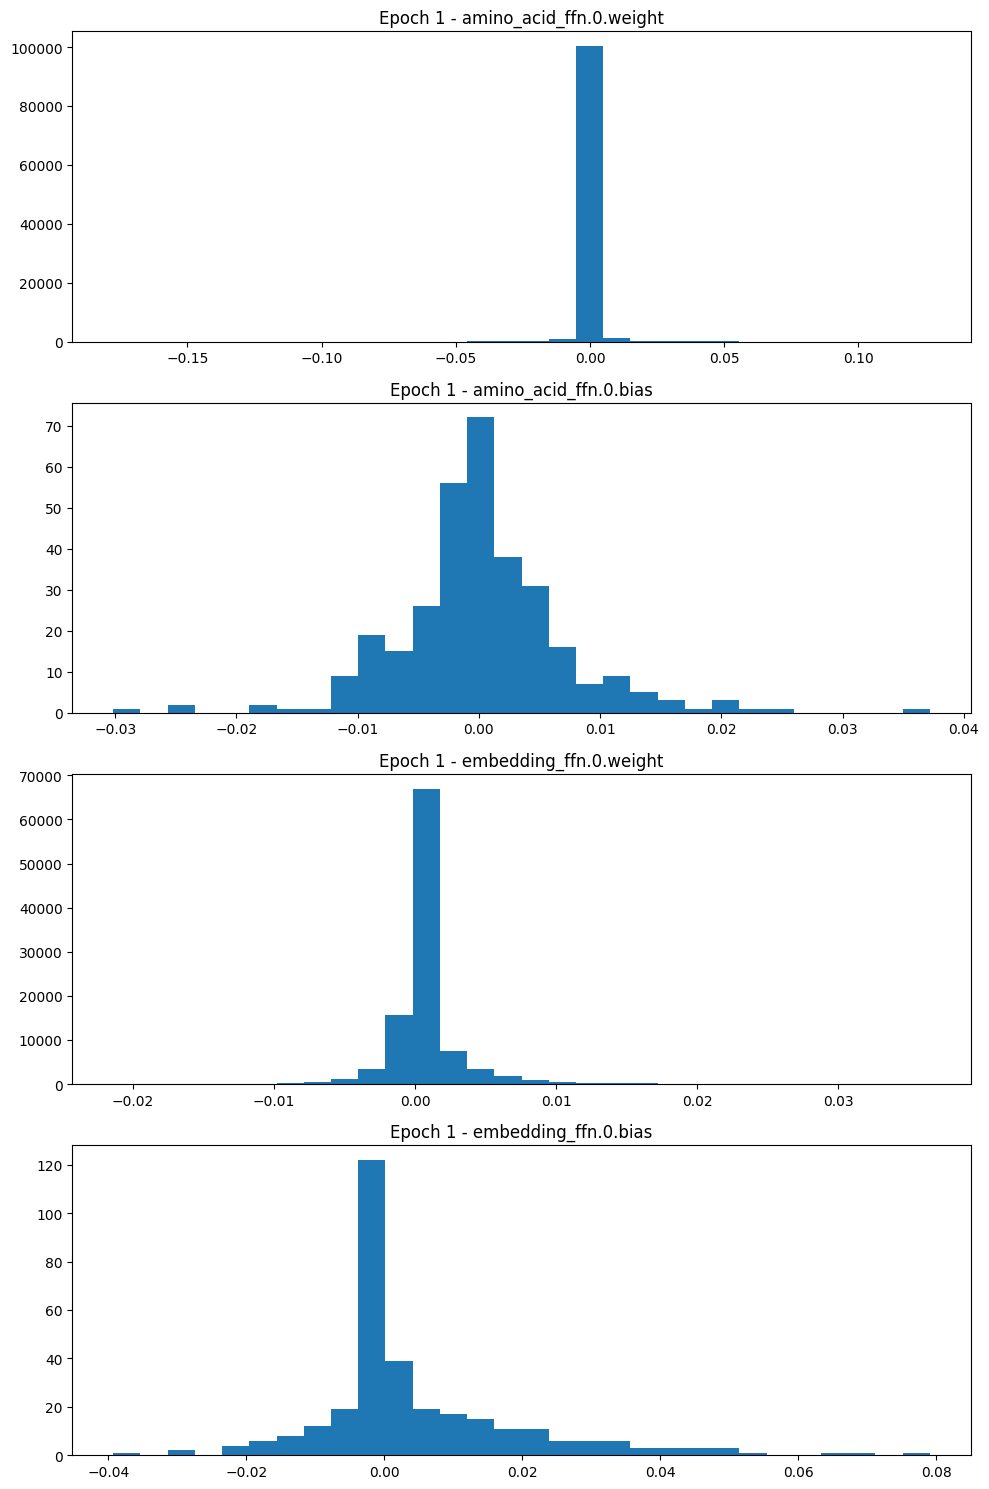

Epoch 1, Test Loss: 3.452736029258141
Epoch 2, Training Loss: 3.21278453707695


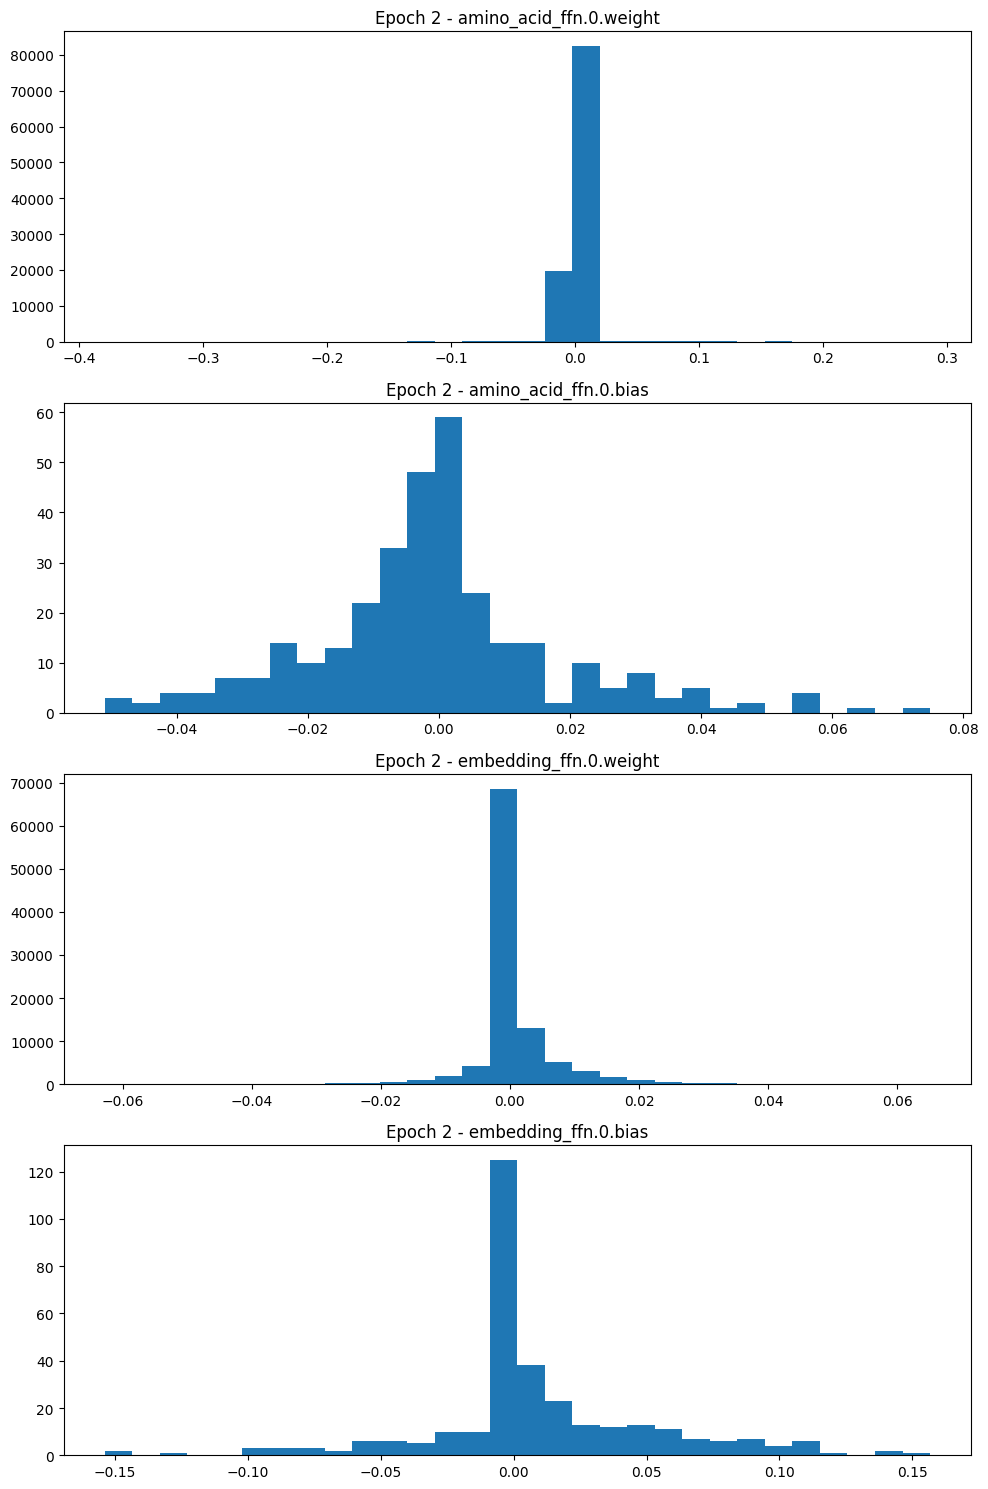

Epoch 2, Test Loss: 3.4063366193037767
Epoch 3, Training Loss: 3.018437007665634


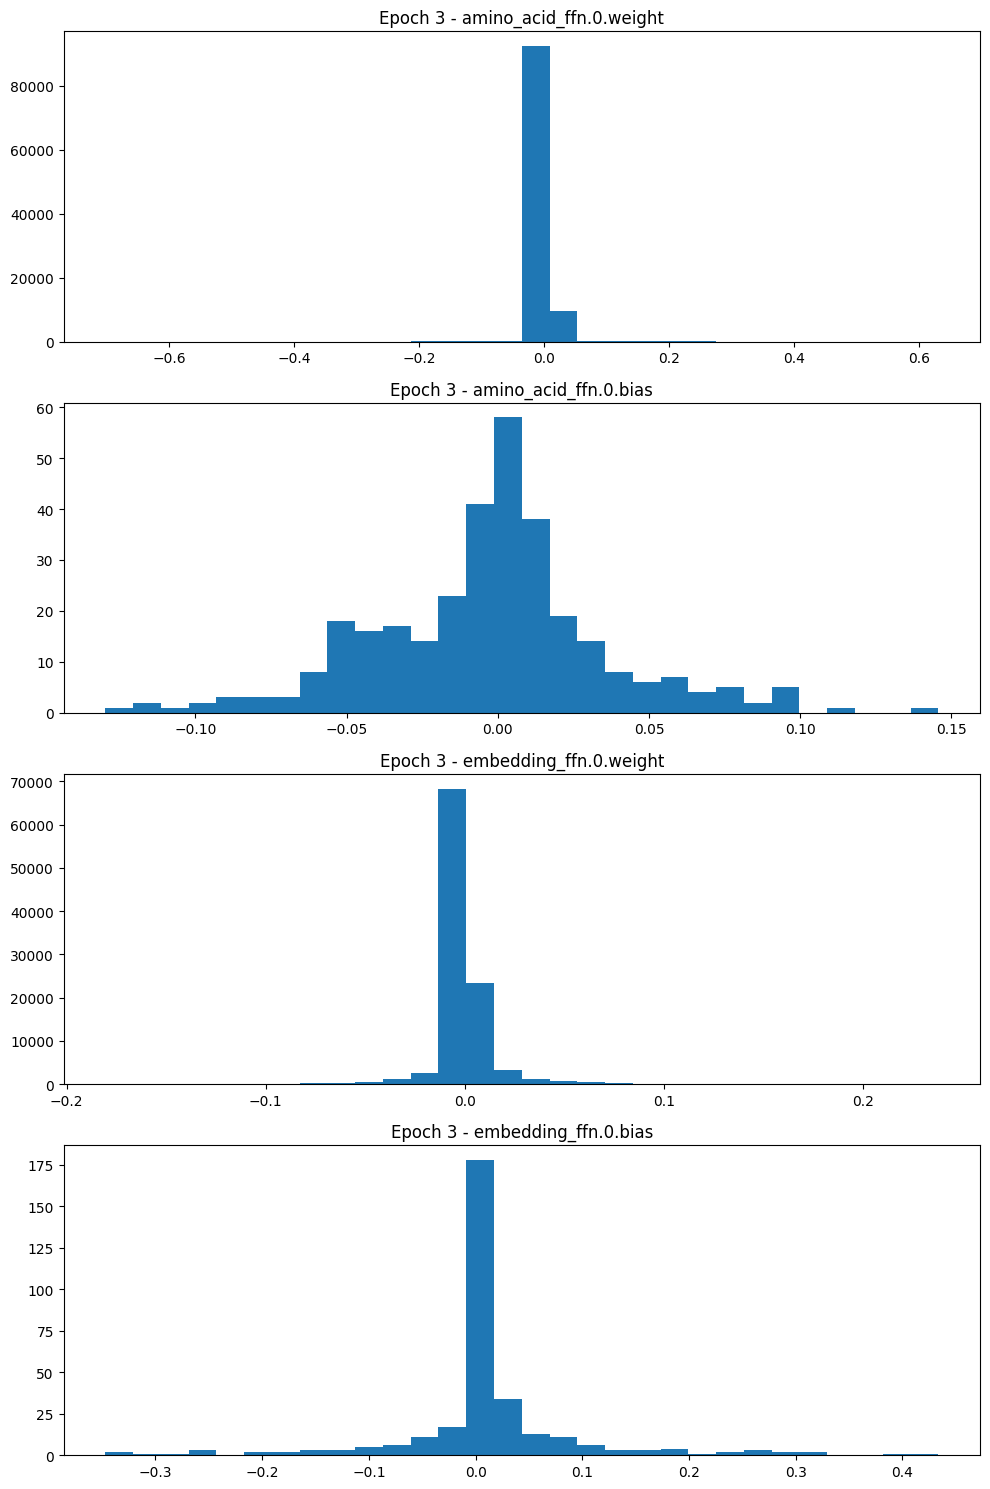

Epoch 3, Test Loss: 3.3494377503028283
Epoch 4, Training Loss: 2.9103140914440155


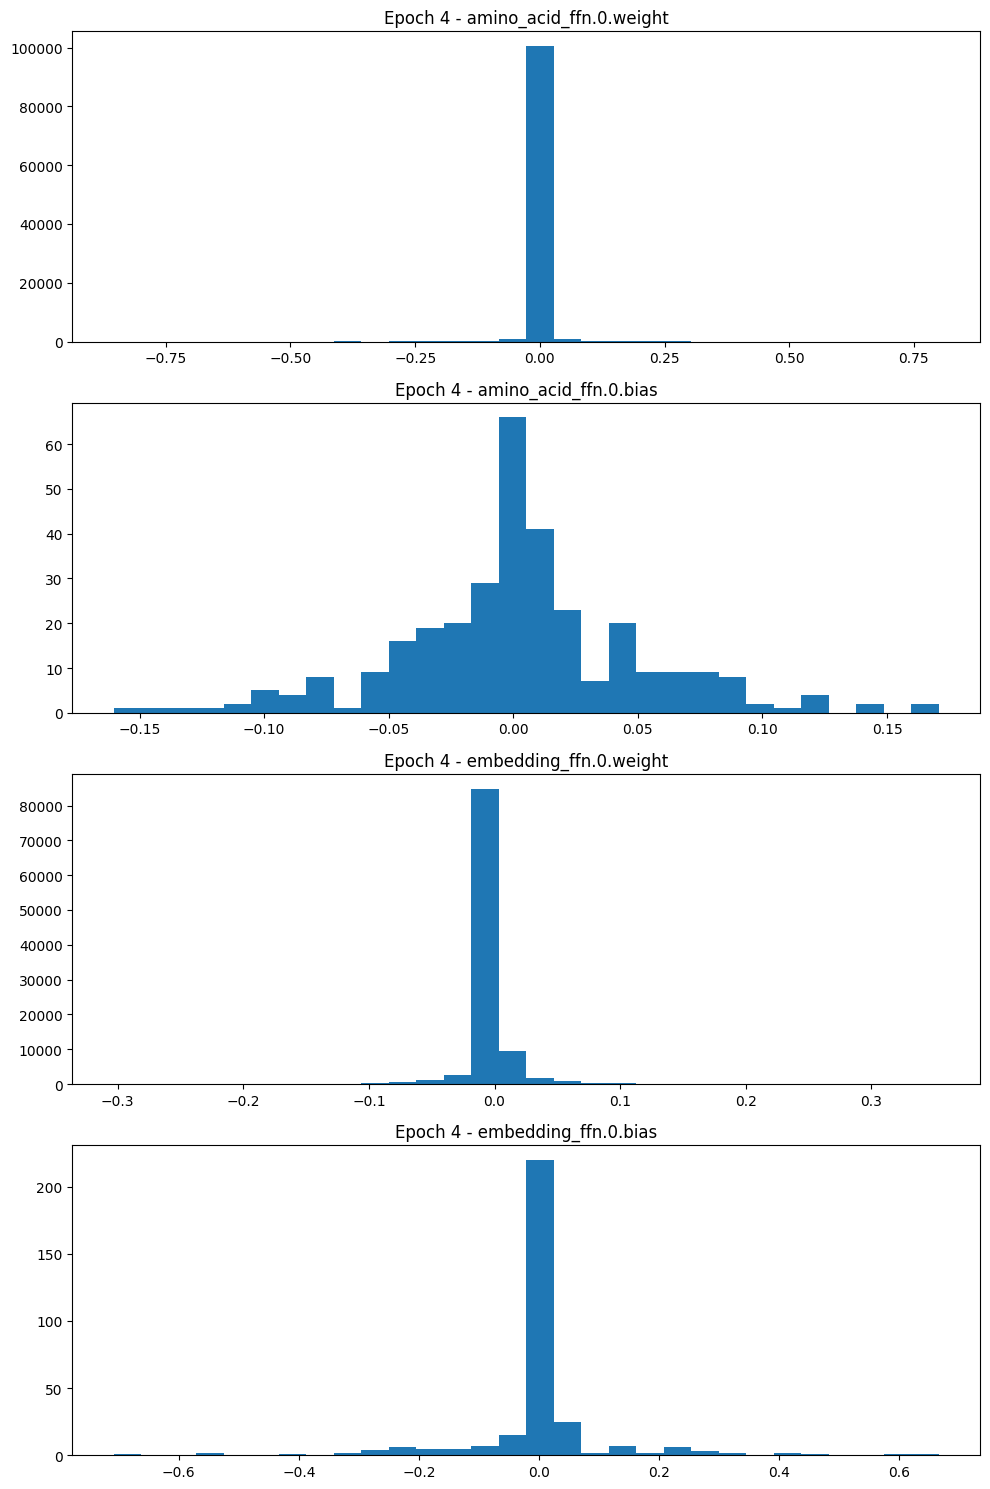

Epoch 4, Test Loss: 3.3159158871724057
Epoch 5, Training Loss: 2.842406629323959


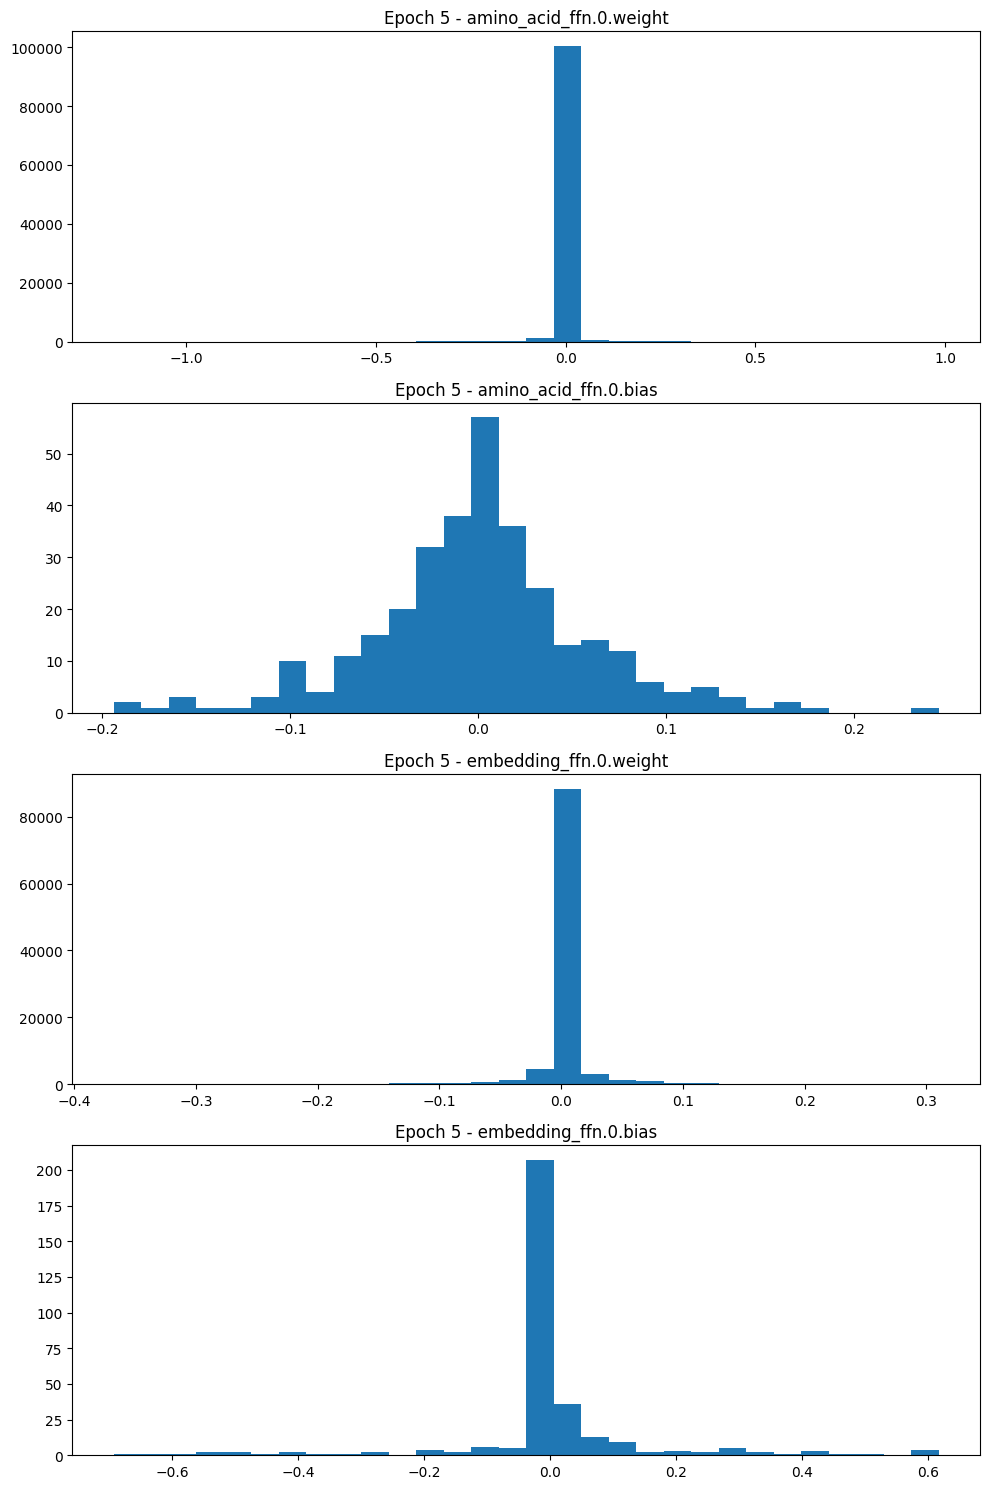

Epoch 5, Test Loss: 3.2963820970975437
Validation Loss of the Best Model: 3.2051775319235665


In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR

class PeptideReceptorDataset(Dataset):
    def __init__(self, peptides, receptors):
        self.peptides = peptides
        self.receptors = receptors

    def __len__(self):
        return len(self.peptides)

    def __getitem__(self, idx):
        return self.peptides[idx], self.receptors[idx]

set_seed()

# create dataset for train, val, and test
train_dataset = PeptideReceptorDataset(train_peptides, train_receptors)
val_dataset = PeptideReceptorDataset(val_peptides, val_receptors)
test_dataset = PeptideReceptorDataset(test_peptides, test_receptors)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

n_embed = 320
h1 = 1  # Number of feedforward layers for amino acid embeddings
h2 = 1  # Number of feedforward layers for averaged embedding
eo = 320  # Output embedding dimension
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_extended_model = ExtendedCLIP(n_embed, h1, h2, eo).to(device)

# keep track of best model
best_test_loss = float('inf')
best_model = None
train_losses = []
test_losses = []
val_losses = []

# training
n_epochs = 5
optimizer = Adam(trained_extended_model.parameters(), lr=1e-4)
# lr decay to avoid nan loss while learning
def lr_lambda(epoch):
    initial_lr = 1e-4
    final_lr = 1e-4 #2e-6
    decay_duration = n_epochs
    decay_factor = (final_lr / initial_lr) ** (1.0 / decay_duration)
    return decay_factor ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# plot the gradients
def plot_gradients(model, epoch):
    fig, axs = plt.subplots(len(list(model.amino_acid_ffn.named_parameters())) + len(list(model.embedding_ffn.named_parameters())), figsize=(10, 15))

    # For amino_acid_ffn
    for ax, (name, param) in zip(axs[:len(list(model.amino_acid_ffn.named_parameters()))], model.amino_acid_ffn.named_parameters()):
        if param.grad is not None:
            ax.hist(param.grad.cpu().numpy().flatten(), bins=30)
            ax.set_title(f"Epoch {epoch + 1} - amino_acid_ffn.{name}")

    # For embedding_ffn
    for ax, (name, param) in zip(axs[len(list(model.amino_acid_ffn.named_parameters())):], model.embedding_ffn.named_parameters()):
        if param.grad is not None:
            ax.hist(param.grad.cpu().numpy().flatten(), bins=30)
            ax.set_title(f"Epoch {epoch + 1} - embedding_ffn.{name}")

    plt.tight_layout()
    plt.show()

for epoch in range(n_epochs):
    total_loss = 0
    trained_extended_model.train()

    skip = 0

    for curr_peptides, curr_receptors in train_loader:
        optimizer.zero_grad()
        pep_tokenized = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
        rec_tokenized = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)
        loss = trained_extended_model(pep_tokenized, rec_tokenized)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        skip += 1
        if skip == 200:
          break

    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / skip}")#len(train_loader)}")
    train_losses.append(total_loss/ skip)# len(train_loader))
    scheduler.step()
    plot_gradients(trained_extended_model, epoch)


    # select model based on test set
    test_loss = 0
    trained_extended_model.eval()
    with torch.no_grad():
        for curr_peptides, curr_receptors in test_loader:
            pep_tokenized = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
            rec_tokenized = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)
            loss = trained_extended_model(pep_tokenized, rec_tokenized)
            test_loss += loss.item()
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}")
    test_losses.append(test_loss/len(test_loader))

    # save the model if it has the best test loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = trained_extended_model.state_dict()

# load the best model after training and selection
trained_extended_model.load_state_dict(best_model)

# actual performance using val set
val_loss = 0
trained_extended_model.eval()
with torch.no_grad():
    for curr_peptides, curr_receptors in val_loader:
        pep_tokenized = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
        rec_tokenized = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)
        loss = trained_extended_model(pep_tokenized, rec_tokenized)
        val_loss += loss.item()
print(f"Validation Loss of the Best Model: {val_loss / len(val_loader)}")


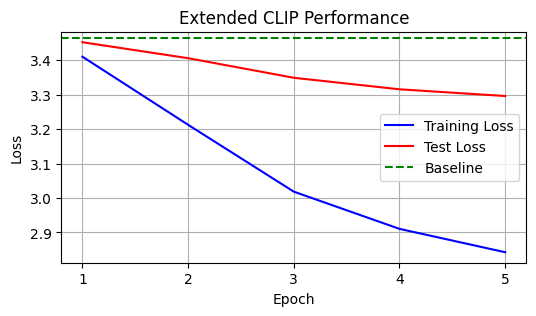

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", color="red")
plt.axhline(y=-torch.tensor(1/batch_size).log().item(), color='green', linestyle='--', label="Baseline")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Extended CLIP Performance")
plt.legend(loc='center right')
plt.grid(True)
plt.xticks(range(1, len(train_losses) + 1))
plt.show()

In [ ]:
type(pep_tokenized)

transformers.tokenization_utils_base.BatchEncoding

In [ ]:
tokenizer.pad_token_id

1

In [ ]:

       h = self.encoder(**aa_idx).last_hidden_state # B, T, D

        # h1 feedforward layers
        for layer in self.amino_acid_ffn:
            h = F.relu(layer(h))

        # Average over the sequence length
        h = h.mean(1)

        # h2 feedforward layers
        for layer in self.embedding_ffn:
            h = F.relu(layer(h))

        # Normalize the embedding
        h = h / h.norm(dim=-1, keepdim=True) + 1e-9
        return h # B, D'


In [ ]:
h = trained_extended_model.encoder(**pep_tokenized).last_hidden_state
for layer in trained_extended_model.amino_acid_ffn:
  h = F.relu(layer(h))

h = h.mean(1)

In [ ]:
pep_tokenized['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [ ]:

h

tensor([[0.1323, 0.1103, 0.0000,  ..., 0.1805, 0.1416, 0.1134],
        [0.1108, 0.1493, 0.0000,  ..., 0.1075, 0.0919, 0.1353],
        [0.1108, 0.1493, 0.0000,  ..., 0.1075, 0.0919, 0.1353],
        ...,
        [0.1227, 0.1568, 0.0000,  ..., 0.2382, 0.1115, 0.0888],
        [0.2285, 0.1765, 0.0000,  ..., 0.1574, 0.2108, 0.0561],
        [0.2460, 0.0954, 0.0000,  ..., 0.1562, 0.1371, 0.0905]],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [ ]:
h = trained_extended_model.embedding_ffn[0](h)
h

tensor([[-0.1449, -0.0945, -0.0728,  ..., -0.0516, -0.0702,  0.0146],
        [-0.1519, -0.0818, -0.0765,  ..., -0.0355, -0.0423, -0.0068],
        [-0.1519, -0.0818, -0.0765,  ..., -0.0355, -0.0423, -0.0068],
        ...,
        [-0.1406, -0.1110, -0.0592,  ..., -0.1038, -0.0869,  0.0418],
        [-0.1453, -0.0301, -0.0793,  ..., -0.0445, -0.0458,  0.0035],
        [-0.1372, -0.0903, -0.0670,  ..., -0.0814, -0.0777,  0.0130]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
F.relu(h)

In [ ]:
trained_extended_model.embedding_ffn[0].weight

Parameter containing:
tensor([[ 0.0324, -0.0242, -0.0016,  ..., -0.0020,  0.0356, -0.0270],
        [-0.0556, -0.0548, -0.0567,  ...,  0.0448,  0.0523,  0.0206],
        [ 0.0353,  0.0388,  0.0377,  ...,  0.0504, -0.0464, -0.0258],
        ...,
        [-0.0183,  0.0071,  0.0043,  ..., -0.0052,  0.0432, -0.0425],
        [-0.0245,  0.0452, -0.0229,  ...,  0.0097, -0.0092,  0.0498],
        [-0.0358, -0.0275, -0.0102,  ...,  0.0256, -0.0179,  0.0504]],
       device='cuda:0', requires_grad=True)

In [ ]:
(peptide_embeddings @ receptor_embeddings.T)

tensor(0.0001, device='cuda:0', grad_fn=<MinBackward1>)

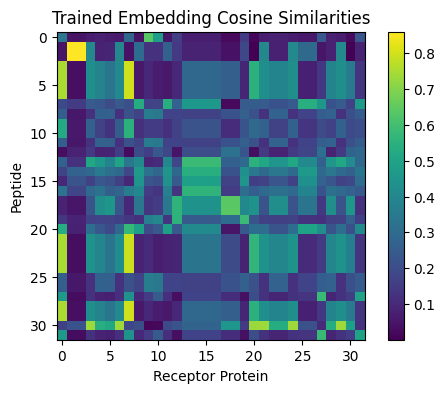

In [ ]:
curr_peptides, curr_receptors = next(iter(val_loader))
pep_tokenized = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
rec_tokenized = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

peptide_embeddings = trained_extended_model.get_embedding(pep_tokenized)
receptor_embeddings = trained_extended_model.get_embedding(rec_tokenized)
cosine_similarity_matrix = torch.nn.functional.cosine_similarity(peptide_embeddings.unsqueeze(1), receptor_embeddings.unsqueeze(0), dim=2)

plt.figure(figsize=(6, 4))
plt.imshow(cosine_similarity_matrix.cpu().detach().numpy(), cmap='viridis')#, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Trained Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

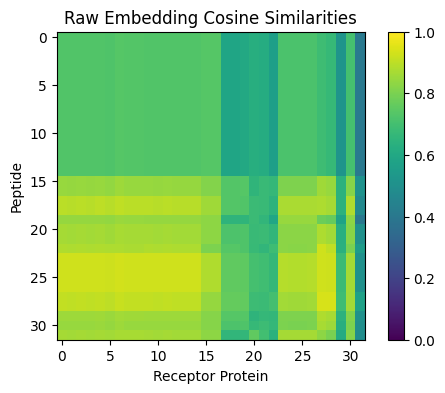

In [ ]:
free_extended_model
raw_peptide_embeddings = trained_extended_model.get_raw_embedding(pep_tokenized)
raw_receptor_embeddings = trained_extended_model.get_raw_embedding(rec_tokenized)
raw_cosine_similarity_matrix = torch.mm(raw_peptide_embeddings, raw_receptor_embeddings.t())

plt.figure(figsize=(6, 4))
plt.imshow(raw_cosine_similarity_matrix.cpu().detach().numpy(), cmap='viridis', vmin=0, vmax=1)
plt.colorbar()
plt.title("Raw Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()


### old vis

In [ ]:
extended_model.cpu()

ExtendedCLIP(
  (encoder): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise

In [ ]:
pep_embedding = extended_model.get_embedding(pep)  # Assuming that pep is correctly formatted
rec_embedding = extended_model.get_embedding(rec)  # Assuming that rec is correctly formatted


In [ ]:
len(pep_batch)

32

In [ ]:
pep_arr = pep_embedding.detach().numpy()
rec_arr = rec_embedding.detach().numpy()

In [ ]:
from torch.nn.functional import cosine_similarity

# cosine_sim = cosine_similarity(pep_embedding, rec_embedding, dim=-1)

cosine_similarities = [[None for _ in range(len(pep_embedding))] for _ in range(len(rec_embedding))]

for i, pep_emb in enumerate(pep_embedding):
    for j, rec_emb in enumerate(rec_embedding):
        cosine_similarities[i][j] = round(torch.cosine_similarity(pep_emb.unsqueeze(0), rec_emb.unsqueeze(0)).detach().numpy()[0], 2)


In [ ]:
print(len(cosine_similarities))

32


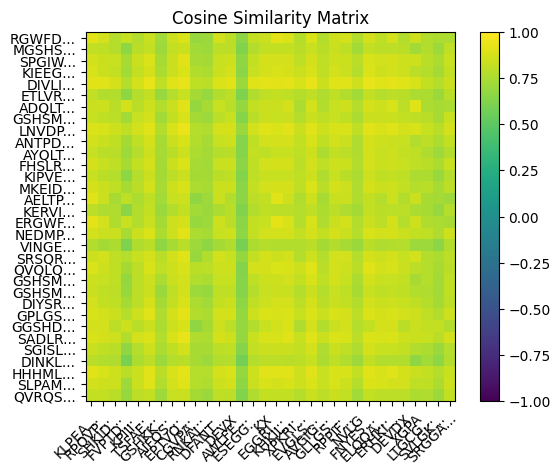

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# a = np.random.random((batch_size, batch_size))
# plt.imshow(cosine_similarities, cmap='hot', interpolation='nearest')

fig, ax = plt.subplots()
im = ax.imshow(cosine_similarities, vmin=-1, vmax=1)

# for i in range(len(rec_embedding)):
#     for j in range(len(pep_embedding)):
#         text = ax.text(j, i, cosine_similarities[i][j],
#                        ha="center", va="center", color="w")

for i, recval in enumerate(rec_batch):
  if len(recval) > 5:
    rec_batch[i] = recval[:5] + '...'

for i, pepval in enumerate(pep_batch):
  if len(pepval) > 5:
    pep_batch[i] = pepval[:5] + '...'

ax.set_xticks(np.arange(batch_size), labels=pep_batch)
ax.set_yticks(np.arange(batch_size), labels=rec_batch)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Cosine Similarity Matrix")
plt.colorbar(im)
# im = ax.imshow(cosine_similarities, vmin=-1, vmax=1)

plt.show()

### old vis part 2

In [ ]:
print(raw_cosine_similarity_matrix[:5, :5])


tensor([[27.0904, 29.0739, 29.3262, 22.5194, 28.9205],
        [27.2676, 29.0024, 29.0086, 23.7628, 29.9762],
        [27.2676, 29.0024, 29.0086, 23.7628, 29.9762],
        [24.0312, 27.5137, 28.0483, 19.5663, 25.5034],
        [26.5028, 27.4826, 27.4031, 23.1295, 29.4795]], device='cuda:0')


In [ ]:
# pep_tokenized.input_ids.detach().cpu().numpy().shape

(21, 29)

In [ ]:
# rec_tokenized.input_ids.detach().cpu().numpy().shape

(21, 667)

In [ ]:
# for i, loss in enumerate(losses):
  # losses[i] = losses[i].detach().cpu().numpy()

AttributeError: ignored

[array(3.4478683, dtype=float32),
 array(3.454324, dtype=float32),
 array(3.4621668, dtype=float32),
 array(3.4579875, dtype=float32),
 array(3.457817, dtype=float32),
 array(3.45263, dtype=float32),
 array(3.4454365, dtype=float32),
 array(3.445618, dtype=float32),
 array(3.4455502, dtype=float32),
 array(3.4402013, dtype=float32),
 array(3.4496312, dtype=float32),
 array(3.4462962, dtype=float32),
 array(3.4275775, dtype=float32),
 array(3.4527836, dtype=float32),
 array(3.4548857, dtype=float32),
 array(3.4576502, dtype=float32),
 array(3.4262807, dtype=float32),
 array(3.4636912, dtype=float32),
 array(3.3870392, dtype=float32),
 array(3.421272, dtype=float32),
 array(3.4062018, dtype=float32),
 array(3.4579222, dtype=float32),
 array(3.4401958, dtype=float32),
 array(3.4219954, dtype=float32),
 array(3.4176846, dtype=float32),
 array(3.4459796, dtype=float32),
 array(3.42452, dtype=float32),
 array(3.3708713, dtype=float32),
 array(3.3589969, dtype=float32),
 array(3.3236105, dtyp

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = F"/content/gdrive/My Drive/clip/firstrun"

torch.save(best_model, PATH)